In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [0]:
#mount google drive on colab for saving session variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')
save_path = "/content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2-CIPHAR10/models/CNN/"
data_path = "/content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2-CIPHAR10/dataset"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#downloaded to drive by colab
DOWNLOAD = True 
#data augmemntation (training accuracy is expected to be lower)
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform)
trainset_trans = torchvision.datasets.CIFAR10(root=data_path, train=True, download=DOWNLOAD, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset_trans, batch_size=5, shuffle=True) #batchsize 50 wont fit, <5 is beeter
train_ac_loader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)
test_ac_loader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=True) #ammortizing error of different lables
test_all_loader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')
print(trainset.data.shape)
print(testset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #in, out, kernel
        self.conv1 = nn.Conv2d(3,   64,  5, 1) #3 32 32, 64 30 30
        self.conv2 = nn.Conv2d(64,  128, 3) #64 15 15, 128 15 15
        self.conv3 = nn.Conv2d(128, 256, 3) #128 7 7, 256 4 4
        self.pool = nn.AvgPool2d(2, 2) 
        self.fc1 = nn.Linear(256*2*2, 128) #256 2 2, 128
        self.fc2 = nn.Linear(128, 256)     #128 256
        self.fc3 = nn.Linear(256, 10)      #256 10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward_h(self, x):
        #print(x.shape)
        a_s = []
        h1 = F.relu(self.conv1(x)) # 3 32 32 64 30 30
        a_s.append(h1)
        p1 = self.pool(h1)  # 64 15 15
        h2 = F.relu(self.conv2(p1)) 
        a_s.append(h2)
        p2 = self.pool(h2) # 128 6 6
        h3 = F.relu(self.conv3(p2)) 
        a_s.append(h3)
        p3 = self.pool(h3) # 256 2 2
        _hidden = p3.view(-1, 256*2*2)
        _hidden = F.relu(self.fc1(_hidden))
        _hidden = F.relu(self.fc2(_hidden))
        y = self.fc3(_hidden)
        a_s.append(y)
        #x = F.log_softmax(x, dim=1)
        return a_s
#testmodel = CNN()
#testmodel(torch.Tensor((np.transpose(testset.data[0:10], (0, 3, 1, 2))))).shape

In [0]:
def calc_accuracy(model, loader, device):
    dataiter = iter(loader)
    data, target  = dataiter.next()
    data, target = data.to(device), target.to(device)
    output = model(data)
    max_index = output.max(dim = 1)[1]
    accuracy = (max_index == target).sum().item()/len(target)
    return accuracy

def train(model, device, train_loader, criterion, optimizer, epoch, model_path = None, save_name = None, rec=None): #model should be to device
    rec = {
        "loss": [],
        "train_ac": [],
        "test_ac": []
    }
    model.train(mode=True)
    batch_size = train_loader.batch_size
    show_frequency = 1000 #show per x data
    for ep_i in range(epoch):
        correct_prediction = 0
        current_loss = 0 #weighted with batch size
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            #forward+backpro
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) #criterion
            correct_prediction += ((output.max(dim = 1)[1] == target).sum().item())
            current_loss += loss.item()*batch_size
            loss.backward()
            optimizer.step()
            #show statistics
            if batch_idx*batch_size % show_frequency == 0 and batch_idx!=0:
                train_loss = current_loss/show_frequency
                current_loss = 0
                train_accuracy = correct_prediction/show_frequency
                correct_prediction = 0
                test_accuracy = calc_accuracy(model, test_ac_loader, device)
                rec["loss"].append(train_loss)
                rec["train_ac"].append(train_accuracy)
                rec["test_ac"].append(test_accuracy)
                print('\repoch {}, interation {}, batchsize {} : loss = {}, train_ac = {}, test_ac = {}'.format(ep_i, batch_idx, batch_size, train_loss, train_accuracy, test_accuracy), end='')
    print('\nFinished Training.')
    model.eval()
    #saving
    if model_path is not None:
        torch.save(model.state_dict(), model_path+save_name)
        print('Saved model parameters to {}.'.format(model_path))

    return rec

In [0]:
#test model code
#model = CNN()
#model(torch.Tensor((np.transpose(testset.data[0:10], (0, 3, 1, 2))))).shape

In [0]:
################################chooese to init or load###############################################
model_path = "/content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2-CIPHAR10/models/CNN/"

INIT = True
LOAD = False
SAVE = True
#init
######################################################################################################
if INIT:
    rec = {
        "loss": [],
        "train_ac": [],
        "test_ac": []
    }
    model = CNN()
    print("Initialized New Network")
#load
######################################################################################################
if LOAD:
    load_path = model_path
    load_model_name = 'cifar-10-avg.pt'
    model = CNN()
    model.load_state_dict(torch.load(load_path+load_model_name))
    print('Loaded model parameters from disk.')
    import pickle
    with open(load_path+"rec-avg.pkl", "rb") as fo: 
        rec = pickle.load(fo)
    print('Loding tranning records from disk.')

if SAVE:
  print('Save Enabled.')
  save_name = 'cifar-10-avg.pt'
  rec_name = "rec2-avg.pkl"
  save_path = model_path
else:
  print('Save NOT!! Enabled.')
  save_name = None
  save_path = None

Initialized New Network
Save Enabled.


In [0]:
#################################use gpu if can  ################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
##train +save to disk"
#########################################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005) #L2 0.01 underfit 0.001 try

new_rec = {"loss": [],"train_ac": [],"test_ac": []}
new_rec = train(model, device, train_loader, criterion, optimizer, epoch=20, model_path=save_path, save_name=save_name, rec=new_rec)
rec["loss"].extend(new_rec["loss"])
rec["train_ac"].extend(new_rec["train_ac"])
rec["test_ac"].extend(new_rec["test_ac"])
if SAVE:
    import pickle
    with open(model_path+rec_name, "wb") as fo: #wb
        pickle.dump(rec,fo)
        print('Saved extended tranning records to disk.')

epoch 19, interation 9800, batchsize 5 : loss = 0.3860239102691412, train_ac = 0.866, test_ac = 0.75
Finished Training.
Saved model parameters to /content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2-CIPHAR10/models/CNN/.
Saved extended tranning records to disk.


In [0]:
if SAVE:
    import pickle
    with open(model_path+rec_name, "wb") as fo: #wb
        pickle.dump(rec,fo)
        print('Saved extended tranning records to disk.')

Saved extended tranning records to disk.


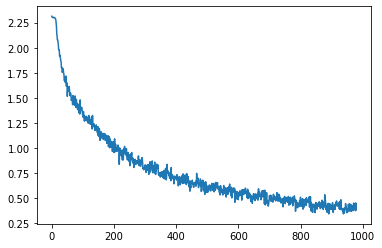

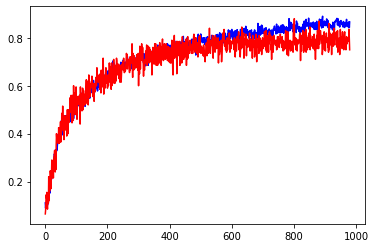

In [0]:
def plot_curve(x):
    plt.figure()
    plt.plot(x)
    plt.show()
plot_curve(rec['loss'])
#plot_curve(rec['train_ac'])
#plot_curve(rec['test_ac'])
plt.figure()
plt.plot(rec['train_ac'], color='blue')
plt.plot(rec['test_ac'], color='red')
plt.show()

In [0]:
calc_accuracy(model, test_all_loader, device)

0.7964

In [0]:
total = 0
print('Tainable Valuables:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print('\nTotal', '\t', total)

Tainable Valuables:
conv1.weight 	 4800
conv1.bias 	 64
conv2.weight 	 73728
conv2.bias 	 128
conv3.weight 	 294912
conv3.bias 	 256
fc1.weight 	 131072
fc1.bias 	 128
fc2.weight 	 32768
fc2.bias 	 256
fc3.weight 	 2560
fc3.bias 	 10

Total 	 540682


In [0]:
def imshow(img): #for 1 data
    # [-1,1] to [0,1]
    img = img / 2 + 0.5   
    if not (type(img).__module__ == np.__name__):
      img = img.numpy()
    # [3,32,32] to [32,32,3]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def show_hidden(model, device, data, idx, n_show_feature): #data.shape = torch.Size()
    assert(data.shape == torch.Size([1,3,32,32]))
    data = data.to(device)
    a_s = model.forward_h(data)
    h1 = a_s[0].detach().cpu().numpy()[idx]
    h2 = a_s[1].detach().cpu().numpy()[idx]

    for i in range(1, 1+n_show_feature):
        #f, axs = plt.subplots(1,n_show_feature,figsize=(1,1))
        plt.subplot(1,n_show_feature,i)
        plt.imshow(h1[i],cmap=plt.cm.binary)
    plt.show()
    for i in range(1, 1+n_show_feature):
        plt.subplot(1,n_show_feature ,i)
        plt.imshow(h2[i],cmap=plt.cm.binary)
    plt.show()
    return 

find mismatch @ 0
label: bird
prediction: horse
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
tensor([[1.6103e-03, 1.1428e-05, 1.2557e-03, 4.7078e-03, 1.3864e-03, 2.1116e-03,
         2.3202e-04, 9.8838e-01, 4.0443e-05, 2.6469e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


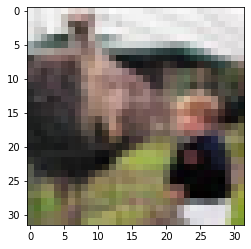

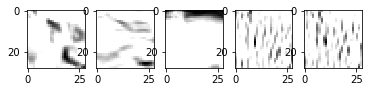

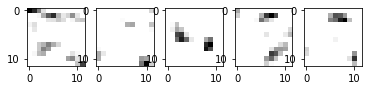

find sample of horse @ 13


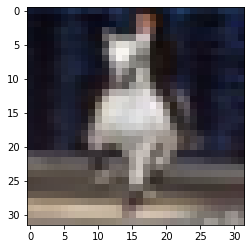

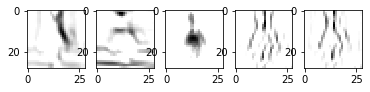

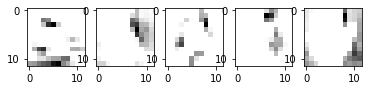

In [0]:
def show_by_mismatch():
    test_one_loader = torch.utils.data.DataLoader(testset, shuffle=True)
    for idx, (data,target) in enumerate(test_one_loader):
        output = model(data.to(device))
        prediction = output.max(dim = 1)[1].cpu()
        #print(target)
        if(prediction != target):
          print("find mismatch @ {}".format(idx))
          print("label: {}".format(classes[target]))
          print("prediction: {}".format(classes[prediction]))
          print(classes)
          print(F.softmax(output, dim=1))
          imshow(data[0])
          show_hidden(model, device, data, 0, 5)
          return prediction, target

def show_by_class(cls):
    test_one_loader = torch.utils.data.DataLoader(testset, shuffle=True)
    for idx, (data,target) in enumerate(test_one_loader):
        if cls == target:
            print("find sample of {} @ {}".format(classes[cls], idx))
            imshow(data[0])
            show_hidden(model, device, data, 0, 5)
            return 

pred, tar = show_by_mismatch()
show_by_class(pred)

find mismatch @ 0
label: deer
prediction: horse
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
tensor([[3.6252e-05, 1.0893e-04, 6.5580e-02, 3.1930e-04, 1.1400e-01, 5.9816e-04,
         3.1306e-05, 8.1927e-01, 1.1951e-05, 4.9279e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


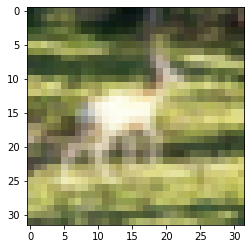

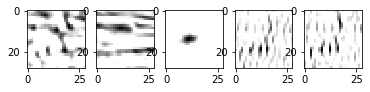

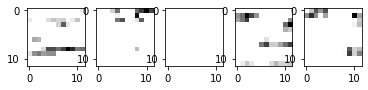

find sample of horse @ 0


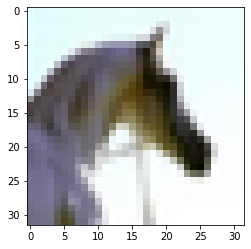

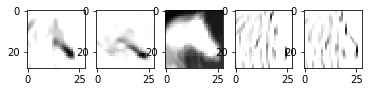

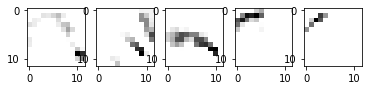

In [0]:
def show_by_mismatch():
    test_one_loader = torch.utils.data.DataLoader(testset, shuffle=True)
    for idx, (data,target) in enumerate(test_one_loader):
        output = model(data.to(device))
        prediction = output.max(dim = 1)[1].cpu()
        #print(target)
        if(prediction != target):
          print("find mismatch @ {}".format(idx))
          print("label: {}".format(classes[target]))
          print("prediction: {}".format(classes[prediction]))
          print(classes)
          print(F.softmax(output, dim=1))
          imshow(data[0])
          show_hidden(model, device, data, 0, 5)
          return prediction, target

def show_by_class(cls):
    test_one_loader = torch.utils.data.DataLoader(testset, shuffle=True)
    for idx, (data,target) in enumerate(test_one_loader):
        if cls == target:
            print("find sample of {} @ {}".format(classes[cls], idx))
            imshow(data[0])
            show_hidden(model, device, data, 0, 5)
            return 

pred, tar = show_by_mismatch()
show_by_class(pred)

In [0]:
CNN()

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

conv1.weight 	 4800


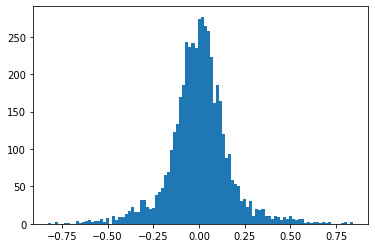

conv1.bias 	 64


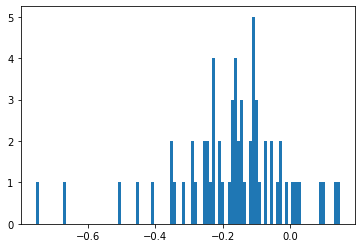

conv2.weight 	 73728


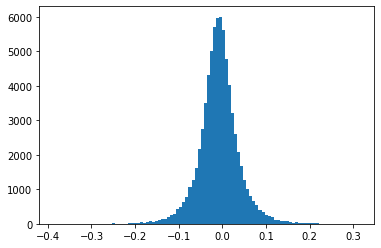

conv2.bias 	 128


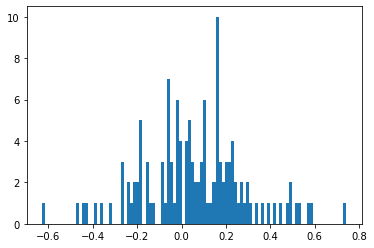

conv3.weight 	 294912


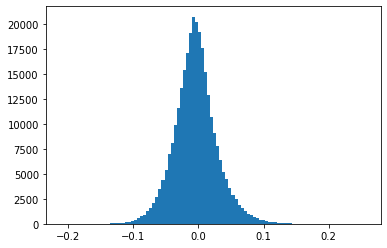

conv3.bias 	 256


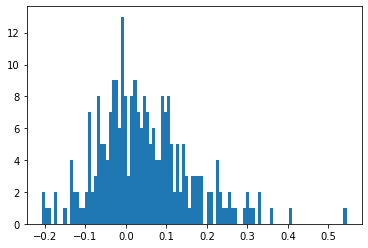

fc1.weight 	 131072


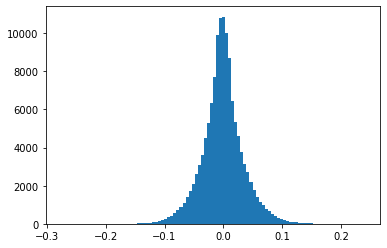

fc1.bias 	 128


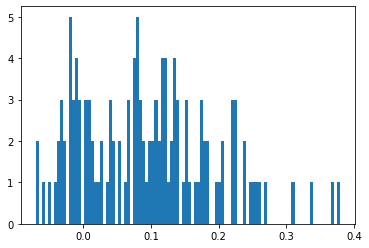

fc2.weight 	 32768


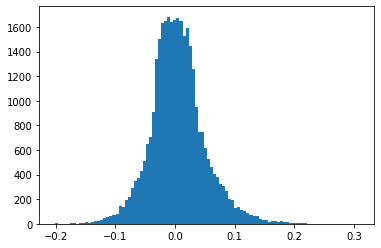

fc2.bias 	 256


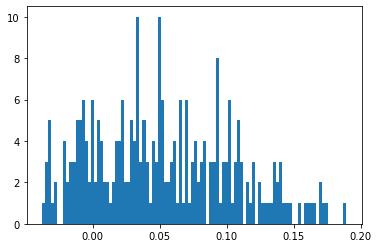

fc3.weight 	 2560


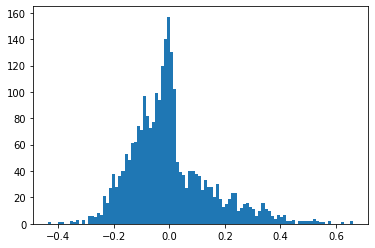

fc3.bias 	 10


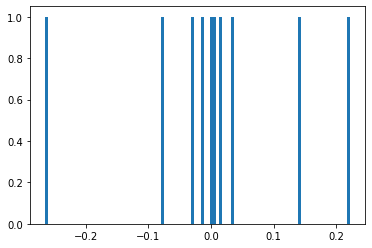

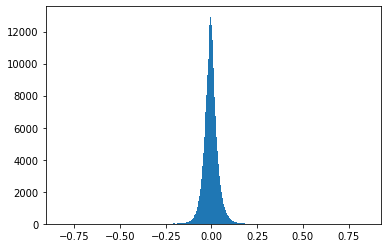

In [0]:
W_all = np.array([])
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        wi_flatten = param.cpu().detach().numpy().flatten()
        W_all = np.r_[W_all, wi_flatten]
        #print(param.cpu().detach().numpy())
        plt.figure()
        plt.hist(wi_flatten,100)
        plt.show()

plt.figure()
plt.hist(W_all,1000)
plt.show()

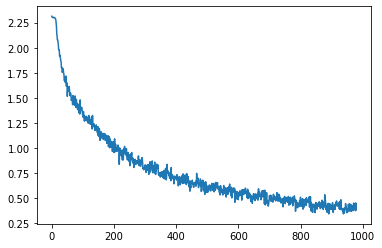

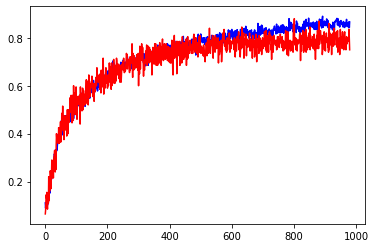

In [0]:
def plot_curve(x):
    plt.figure()
    plt.plot(x)
    plt.show()
plot_curve(rec['loss'])
#plot_curve(rec['train_ac'])
#plot_curve(rec['test_ac'])
plt.figure()
plt.plot(rec['train_ac'], color='blue')
plt.plot(rec['test_ac'], color='red')
plt.show()

In [0]:
def imshow(img): #for 1 data
    # [-1,1] to [0,1]
    img = img / 2 + 0.5   
    if not (type(img).__module__ == np.__name__):
      img = img.numpy()
    # [3,32,32] to [32,32,3]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

def show_hidden(model, device, data, idx, n_show_feature): #data.shape = torch.Size()
    assert(data.shape == torch.Size([1,3,32,32]))
    data = data.to(device)
    a_s = model.forward_h(data)
    h1 = a_s[0].detach().cpu().numpy()[idx]
    h2 = a_s[1].detach().cpu().numpy()[idx]

    for i in range(1, 1+n_show_feature):
        #f, axs = plt.subplots(1,n_show_feature,figsize=(1,1))
        plt.subplot(1,n_show_feature,i)
        plt.imshow(h1[i],cmap=plt.cm.binary)
    plt.show()
    for i in range(1, 1+n_show_feature):
        plt.subplot(1,n_show_feature ,i)
        plt.imshow(h2[i],cmap=plt.cm.binary)
    plt.show()
    return 

def show_by_mismatch():
    test_one_loader = torch.utils.data.DataLoader(testset, shuffle=True)
    for idx, (data,target) in enumerate(test_one_loader):
        output = model(data.to(device))
        prediction = output.max(dim = 1)[1].cpu()
        #print(target)
        if(prediction != target):
          print("find mismatch @ {}".format(idx))
          print("label: {}".format(classes[target]))
          print("prediction: {}".format(classes[prediction]))
          print(classes)
          print(F.softmax(output, dim=1))
          imshow(data[0])
          show_hidden(model, device, data, 0, 5)
          return prediction, target

def show_by_class(cls):
    test_one_loader = torch.utils.data.DataLoader(testset, shuffle=True)
    for idx, (data,target) in enumerate(test_one_loader):
        if cls == target:
            print("find sample of {} @ {}".format(classes[cls], idx))
            imshow(data[0])
            show_hidden(model, device, data, 0, 5)
            return 

find mismatch @ 2
label: frog
prediction: deer
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
tensor([[0.0018, 0.0021, 0.0283, 0.0495, 0.5525, 0.0743, 0.1736, 0.1149, 0.0006,
         0.0023]], device='cuda:0', grad_fn=<SoftmaxBackward>)


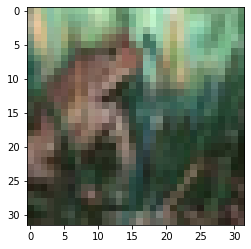

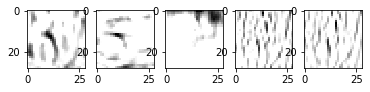

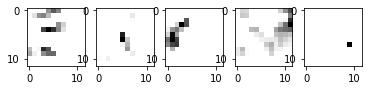

find sample of deer @ 3


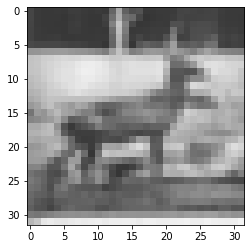

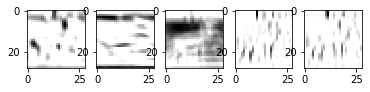

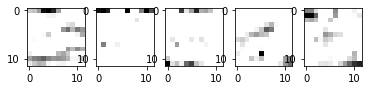

In [0]:
pred, tar = show_by_mismatch()
show_by_class(pred)